Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# With Automated Machine Learning
### Energy Demand Forecasting ###

Automated ML empowers data scientists like me to identify an end-to-end machine learning pipeline for any problem, and I am able to achieve higher accuracy while spending far less of my time. 

It enables a much larger number of experiments to be run.

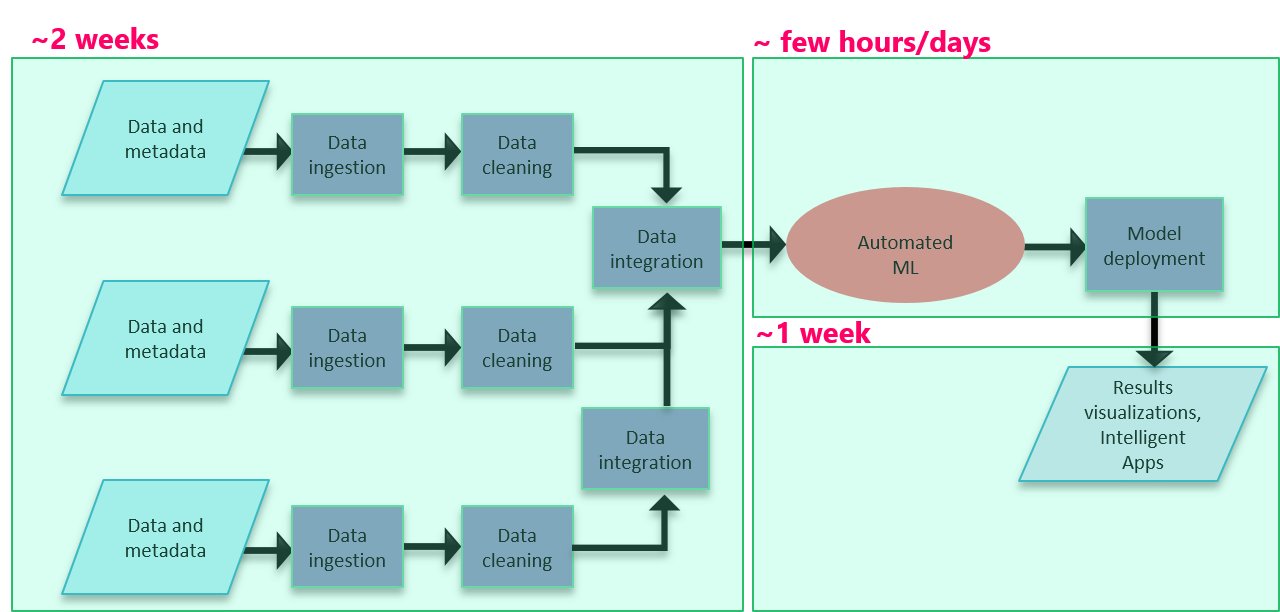

In [1]:
from IPython.display import Image
Image(filename='./WithAutoML.png',width=900)

## Introduction
In this example, we show how AutoML can be used for energy demand forecasting. Make sure you have executed the [configuration](../../../configuration.ipynb) before running this notebook.

In this notebook we will walk through the following steps:
1. Creating an experiment in an existing Workspace


2. Ingesting energy data and enriching it with weather data from Azure Open Datasets

    2.1 - Inspect data
    
    2.2 - Split the data into train and test sets


3. Instantiating AutoMLConfig for Automated ML


4. Training your model using local compute


5. Exploring the results and retrieve the best model
    
    5.1 - View the engineered names for featurized data
    
    5.2 - Test the best fitted model
    
    5.3 - Calculate accuracy metrics
    
    5.4 - Model Explainability: what features matter for the forecast?
    
       
6. Registering and deploying your model

    6.1 Define your entry script & dependencies
    
    6.2 Define your deployment configuration

## Section 1. Creating an experiment in an existing workspace 
As part of the setup you have already created a <b>Workspace</b>. For AutoML you would need to create an <b>Experiment</b>. An <b>Experiment</b> is a named object in a <b>Workspace</b>, which is used to run experiments.

In [2]:
import azureml.core
import pandas as pd
import numpy as np
import logging
import warnings
# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None


from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### <font color="red">Action Required #1</font>

<font color="red"> Replace <resource_group>, <workspace_region>, and <workspace_name> with the values from paper slip you received. Make sure you remove the angle brackets. The values should be inside the quotes. </font>

In [3]:
#AutoML Workshop subscription
subscription_id = "ba7979f7-d040-49c9-af1a-7414402bf622"
resource_group = "Test"
workspace_region = "eastus2"
workspace_name = "Anumamah-test"

print(subscription_id)
print(resource_group)
print(workspace_region)
print(workspace_name)

In [4]:
from azureml.core import Workspace

# Create the workspace using the specified parameters
ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = workspace_region,
                      create_resource_group = True,
                      exist_ok = True)
ws.get_details()

# write the details of the workspace to a configuration file to the notebook library
ws.write_config()

### <font color="red"> Action Required #2
    
<font color="red"> Executing next cell will ask you to go to a url to authenticate. Follow the instructions and copy and paste the code given. Some times space at the end after pasting the code. Once the authentication is successful, you will see a message that says Interactive authentication successfully completed. In this step you are logging into the Azure subscription using your corporate credentials </font>

In [ ]:
ws = Workspace(workspace_name = workspace_name,
               subscription_id = subscription_id,
               resource_group = resource_group)

### <font color="red"> Action Required - Experiment Name
    
<font color="red"> uncomment (by removing # sign at the front) the experiment_name line (2nd line) and replace the <experiment_name> with your alias </font>

In [5]:
# choose a name for the run history container in the workspace
experiment_name = 'anumamah'

# project folder
project_folder = './sample_projects/automl-energydemandforecasting'

experiment=Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

,
SDK version,1.0.33
Subscription ID,ba7979f7-d040-49c9-af1a-7414402bf622
Workspace Name,Anumamah-test
Resource Group,Test
Location,eastus2
Project Directory,./sample_projects/automl-energydemandforecasting
Experiment Name,anumamah


## Section 2. Ingesting energy data and enriching it with weather data from Azure Open Datasets Data

In [6]:
data = pd.read_csv("nyc_energy.csv", parse_dates=['timeStamp'])

### 2.1 Inspect data
Display the first few rows of the data

In [7]:
data.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.50,0.00,46.13
1,2012-01-01 01:00:00,4752.10,0.00,45.89
2,2012-01-01 02:00:00,4542.60,0.00,45.04
3,2012-01-01 03:00:00,4357.70,0.00,45.03
4,2012-01-01 04:00:00,4275.50,0.00,42.61


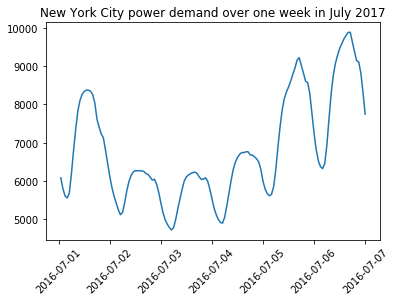

In [8]:
plt_df = data.loc[(data.timeStamp>'2016-07-01') & (data.timeStamp<='2016-07-07')]
plt.plot(plt_df['timeStamp'], plt_df['demand'])
plt.title('New York City power demand over one week in July 2017')
plt.xticks(rotation=45)
plt.show()

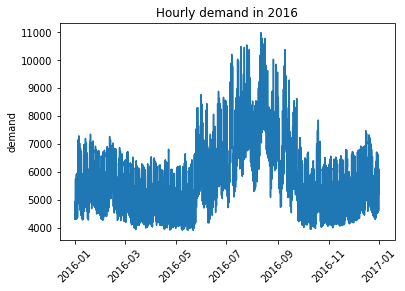

In [9]:
plt_df = data.copy().loc[(data['timeStamp']>='2016-01-01') & (data['timeStamp']<'2017-01-01'), ]
plt.plot(plt_df['timeStamp'], plt_df['demand'], markersize=1)
plt.title('Hourly demand in 2016')
plt.ylabel('demand')
plt.xticks(rotation=45)
plt.show()

### 2.2 Split the data into train and test sets


In [10]:
# let's take note of what columns means what in the data
time_column_name = 'timeStamp'
target_column_name = 'demand'

X_train = data[data[time_column_name] < '2017-02-01']
X_test = data[data[time_column_name] >= '2017-02-01']
y_train = X_train.pop(target_column_name).values
y_test = X_test.pop(target_column_name).values

## Section 3. Instantiating AutoMLConfig for Automated ML

Here we are using new task type "forecasting" for timeseries data training, and other timeseries related settings to instantiate a AutoMLConfig object.

What I love the most of Automated ML is that even if it accelerates my work as data scientist, I still have total <b>Control</b>, <b>Transparency</b>, <b>Visibility</b> on what I am doing with my data, the training piece and all the metrics it is using to evaluate different ML approaches.

Below there is the <b>Configuration file</b> for submitting an Automated Machine Learning experiment in Azure Machine Learning service.

This configuration object contains and persists the parameters for configuring the experiment run parameters, as well as the training data to be used at run time.


|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>
|**iterations**|Number of iterations. In each iteration, Auto ML trains a specific pipeline on the given data|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], targets values.|
|**n_cross_validations**|Number of cross validation splits.|
|**path**|Relative path to the project folder.  AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder. 

### <font color="red"> Action Required #3 </font> 
<font color="red"> AutoML comes with many levers that you can use to configure. This is to give you flexibility and control  
For example primary_metric is the metric that AutoML use to optimize the machine learning model it is building. AutoML supports several different primary_metrics. Replace <primary_metric> with <b> normalized_root_mean_squared_error </b> which we will be using as primary metric for this forecasting task. To find out more about all the configuration settings you can leisurely read at ( https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train ) </font>
    
Notice that the task is set to forecasting. We are also passing the training dataset and validation dataset (X_train, y_train that we prepared in section 2.2).

In [11]:
automl_settings = {
    "time_column_name": time_column_name    
}


automl_config = AutoMLConfig(task = 'forecasting',
                             debug_log = 'automl_nyc_energy_errors.log',
                             primary_metric= 'normalized_root_mean_squared_error',
                             iterations = 10,
                             iteration_timeout_minutes = 5,
                             X = X_train,
                             y = y_train,
                             n_cross_validations = 3,
                             path=project_folder,
                             verbosity = logging.INFO,
                            **automl_settings)

## 4. Training your model 

### 4.1 Using local compute
Submitting the configuration will start a new run in this experiment. For local runs, the execution is synchronous.
You will see the currently running iterations printing to the console.

In [12]:
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_86981773-65f8-49bb-891a-2632708aff07
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   RobustScaler ElasticNet                        0:00:30       0.0504    0.0504
         1   StandardScalerWrapper ElasticNet               0:00:20       0.0349    0.0349
         2   StandardScalerWrapp

In [13]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
anumamah,AutoML_86981773-65f8-49bb-891a-2632708aff07,automl,NotStarted,Link to Azure Portal,Link to Documentation


In [14]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

### 4.2 Using AML Compute
In the following cells, you will not train the model against the data you just downloaded using the resources provided by Azure Notebooks. Instead, you will deploy an Azure ML Compute cluster that will download the data and use Auto ML to train multiple models, evaluate the performance and allow you to retrieve the best model that was trained. In other words, all of the training will be performed remotely with respect to this notebook.

As you will see this is almost entirely done thru configuration, with very little code required.

#### Create the data loading script for remote compute
The Azure Machine Learning Compute cluster needs to know how to get the data to train against. You can package this logic in a script that will be executed by the compute when it starts executing the training.

Run the following cells to locally create the get_data.py script that will be deployed to remote compute. You will also use this script when you want train the model locally.

Observe that the get_data method returns the features (X) and the labels (Y) in an object. This structure is expected later when you will configure Auto ML.

In [50]:
import os

# create project folder
if not os.path.exists(project_folder):
    os.makedirs(project_folder)

In [51]:
%%writefile $project_folder/get_data.py

import pandas as pd
import numpy as np

def get_data():
    time_column_name = 'timeStamp'
    target_column_name = 'demand'
    data = pd.read_csv("https://anumamahstorage427978d3d.blob.core.windows.net/data/nyc_energy.csv", parse_dates=['timeStamp'])
    X = data[data[time_column_name] < '2017-02-01']
    y = X.pop(target_column_name).values


    return { "X" : X, "y" : y }

Overwriting ./sample_projects/automl-energydemandforecasting/get_data.py


#### Create AML Compute Cluster
Now you are ready to create the compute cluster. Run the following cell to create a new compute cluster (or retrieve the existing cluster if it already exists). The code below will create a CPU based cluster where each node in the cluster is of the size STANDARD_D12_V2, and the cluster will have at most 4 such nodes.

In [52]:
### Create AML CPU based Compute Cluster
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
cluster_name = "cpucluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                           max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    compute_target.wait_for_completion(show_output=True)

# Use the 'status' property to get a detailed status for the current AmlCompute. 
#print(compute_target.status.serialize())

Found existing compute target.


Run the following cell to create the configuration.

In [53]:
automl_config = AutoMLConfig(task = 'forecasting',
                             iterations = 10,
                             iteration_timeout_minutes = 5, 
                             time_column_name =  'timeStamp', 
                             primary_metric = 'normalized_root_mean_squared_error',
                             n_cross_validations = 3,
                             debug_log = 'automl.log',
                             verbosity = logging.DEBUG,
                             data_script = project_folder + "/get_data.py",
                             compute_target = compute_target,
                             path = project_folder)
remote_run = experiment.submit(automl_config, show_output=False)
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
anumamah,AutoML_6b50749e-8dea-4912-ab96-4f73d2ce9e04,automl,NotStarted,Link to Azure Portal,Link to Documentation


Once the above cell completes, the run is starting but will likely have a status of Preparing for you. To wait for the run to complete before continuing (and to view the training status updates as they happen), run the following cell. The first time you run this, it will take about 12-15 minutes to complete as the cluster is configured and then the AutoML job is run. Output will be streamed as the tasks progress):

In [54]:
remote_run.wait_for_completion(show_output=True)


****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   RobustScaler ElasticNet                        0:00:58       0.0504    0.0504
         1   StandardScalerWrapper ElasticNet               0:00:39       0.0349    0.0349
         2   StandardScalerWrapper ElasticNet               0:00:39       0.0444    0.0349
         3   StandardScalerWrapper RandomForest             0:00:48       0.0069    0.0069
         4   StandardScalerWrapper LightGBM                 0:00:53       0.0173    

{'runId': 'AutoML_6b50749e-8dea-4912-ab96-4f73d2ce9e04',
 'target': 'cpucluster',
 'status': 'Completed',
 'startTimeUtc': '2019-06-04T22:54:10.536631Z',
 'endTimeUtc': '2019-06-04T23:02:21.353778Z',
 'properties': {'num_iterations': '10',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'MaxTimeSeconds': '300',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'cpucluster',
  'RawAMLSettingsString': "{'name': 'anumamah', 'path': './sample_projects/automl-energydemandforecasting', 'subscription_id': 'ba7979f7-d040-49c9-af1a-7414402bf622', 'resource_group': 'Test', 'workspace_name': 'Anumamah-test', 'region': 'eastus2', 'compute_target': 'cpucluster', 'spark_service': None, 'iterations': 10, 'primary_metric': 'normalized_root_mean_squared_error', 'task_type': 'regression', 'data_script': './sample_projects/automl-energydemandforecasting/get_data.py', 'validation_size

## 5. Exploring the results and retrieve the best model
Below we select the best pipeline from our iterations. 

The get_output file allows you to retrieve the best run and fitted model for any logged metric or a particular iteration.

In [25]:
best_run, fitted_model = local_run.get_output()
fitted_model.steps

[('timeseriestransformer', TimeSeriesTransformer(logger=None)),
 ('prefittedsoftvotingregressor',
  <azureml.train.automl._vendor.automl.client.core.common.model_wrappers.PreFittedSoftVotingRegressor at 0x7eff7da58e80>)]

In [55]:
best_run, fitted_model = remote_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: anumamah,
Id: AutoML_6b50749e-8dea-4912-ab96-4f73d2ce9e04_8,
Type: azureml.scriptrun,
Status: Completed)
ForecastingPipelineWrapper(pipeline=Pipeline(memory=None,
     steps=[('timeseriestransformer', TimeSeriesTransformer(logger=None)), ('prefittedsoftvotingregressor', <azureml.train.automl._vendor.automl.client.core.common.model_wrappers.PreFittedSoftVotingRegressor object at 0x7eff7dad9d68>)]),
              stddev=None)


Widget for monitoring runs
Initial run could take a few minutes. Depending on the data and number of iterations this can run for while. You will see the currently running iterations printing in the widget. The widget will sit on "loading" until the first iteration completed, then you will see an auto-updating graph and table show up. It refreshed once per minute, so you should see the graph update as child runs complete.

NOTE: The widget displays a link at the bottom. Ignore the link for a moment. This links to a web-ui to explore the individual run details.

### <font color = "red"> Action Required #5 </font>
<font color = "red"> When the widget loads you will notice that the two runs failed. This is expected. Click on any of the failed links under Pipeline column. A pop-up window will open. Notice the second line from the bottom in the popup window.  </font>

By the way, the blue bar in the widget might be displaying Waiting for metrics. Ignore that. If you see AttributeError, you can ignore that too (We are running more than a month's old version of SDK on Azure Notebooks and the bug has been fixed in the newer version of SDK).

In [56]:
from azureml.widgets import RunDetails
RunDetails(local_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

In [57]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

### 5.1 View the engineered names for featurized data
Below we display the engineered feature names generated for the featurized data using the time-series featurization.

In [58]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['precip',
 'temp',
 'precip_WASNULL',
 'temp_WASNULL',
 'year',
 'half',
 'quarter',
 'month',
 'day',
 'hour',
 'am_pm',
 'hour12',
 'wday',
 'qday',
 'week']

### 5.2 Test the Best Fitted Model

For forecasting, we will use the `forecast` function instead of the `predict` function. There are two reasons for this.

We need to pass the recent values of the target variable `y`, whereas the scikit-compatible `predict` function only takes the non-target variables `X`. In our case, the test data immediately follows the training data, and we fill the `y` variable with `NaN`. The `NaN` serves as a question mark for the forecaster to fill with the actuals. Using the forecast function will produce forecasts using the shortest possible forecast horizon. The last time at which a definite (non-NaN) value is seen is the _forecast origin_ - the last time when the value of the target is known. 

Using the `predict` method would result in getting predictions for EVERY horizon the forecaster can predict at. This is useful when training and evaluating the performance of the forecaster at various horizons, but the level of detail is excessive for normal use.

In [59]:
# Replace ALL values in y_pred by NaN. 
# The forecast origin will be at the beginning of the first forecast period
# (which is the same time as the end of the last training period).
y_query = y_test.copy().astype(np.float)
y_query.fill(np.nan)
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_fcst, X_trans = fitted_model.forecast(X_test, y_query)

In [60]:
# limit the evaluation to data where y_test has actuals
def align_outputs(y_predicted, X_trans, X_test, y_test, predicted_column_name = 'predicted'):
    """
    Demonstrates how to get the output aligned to the inputs
    using pandas indexes. Helps understand what happened if
    the output's shape differs from the input shape, or if
    the data got re-sorted by time and grain during forecasting.
    
    Typical causes of misalignment are:
    * we predicted some periods that were missing in actuals -> drop from eval
    * model was asked to predict past max_horizon -> increase max horizon
    * data at start of X_test was needed for lags -> provide previous periods
    """
    df_fcst = pd.DataFrame({predicted_column_name : y_predicted})
    # y and X outputs are aligned by forecast() function contract
    df_fcst.index = X_trans.index
    
    # align original X_test to y_test    
    X_test_full = X_test.copy()
    X_test_full[target_column_name] = y_test

    # X_test_full's does not include origin, so reset for merge
    df_fcst.reset_index(inplace=True)
    X_test_full = X_test_full.reset_index().drop(columns='index')
    together = df_fcst.merge(X_test_full, how='right')
    
    # drop rows where prediction or actuals are nan 
    # happens because of missing actuals 
    # or at edges of time due to lags/rolling windows
    clean = together[together[[target_column_name, predicted_column_name]].notnull().all(axis=1)]
    return(clean)

df_all = align_outputs(y_fcst, X_trans, X_test, y_test)
df_all.head()

,timeStamp,_automl_dummy_grain_col,predicted,precip,temp,demand
0,2017-02-01 00:00:00,_automl_dummy_grain_col,5037.08,0.00,31.45,5090.62
1,2017-02-01 01:00:00,_automl_dummy_grain_col,4977.23,0.00,32.44,4839.25
2,2017-02-01 02:00:00,_automl_dummy_grain_col,4906.75,0.00,33.19,4702.52
3,2017-02-01 03:00:00,_automl_dummy_grain_col,4899.44,0.00,33.61,4629.94
4,2017-02-01 04:00:00,_automl_dummy_grain_col,4913.98,0.00,32.30,4653.38


Looking at `X_trans` is also useful to see what featurization happened to the data.

### Calculate accuracy metrics


In [61]:
def MAPE(actual, pred):
    """
    Calculate mean absolute percentage error.
    Remove NA and values where actual is close to zero
    """
    not_na = ~(np.isnan(actual) | np.isnan(pred))
    not_zero = ~np.isclose(actual, 0.0)
    actual_safe = actual[not_na & not_zero]
    pred_safe = pred[not_na & not_zero]
    APE = 100*np.abs((actual_safe - pred_safe)/actual_safe)
    return np.mean(APE)

Simple forecasting model
[Test Data] 
Root Mean squared error: 513.21
mean_absolute_error score: 379.77
MAPE: 6.34


<IPython.core.display.Javascript object>


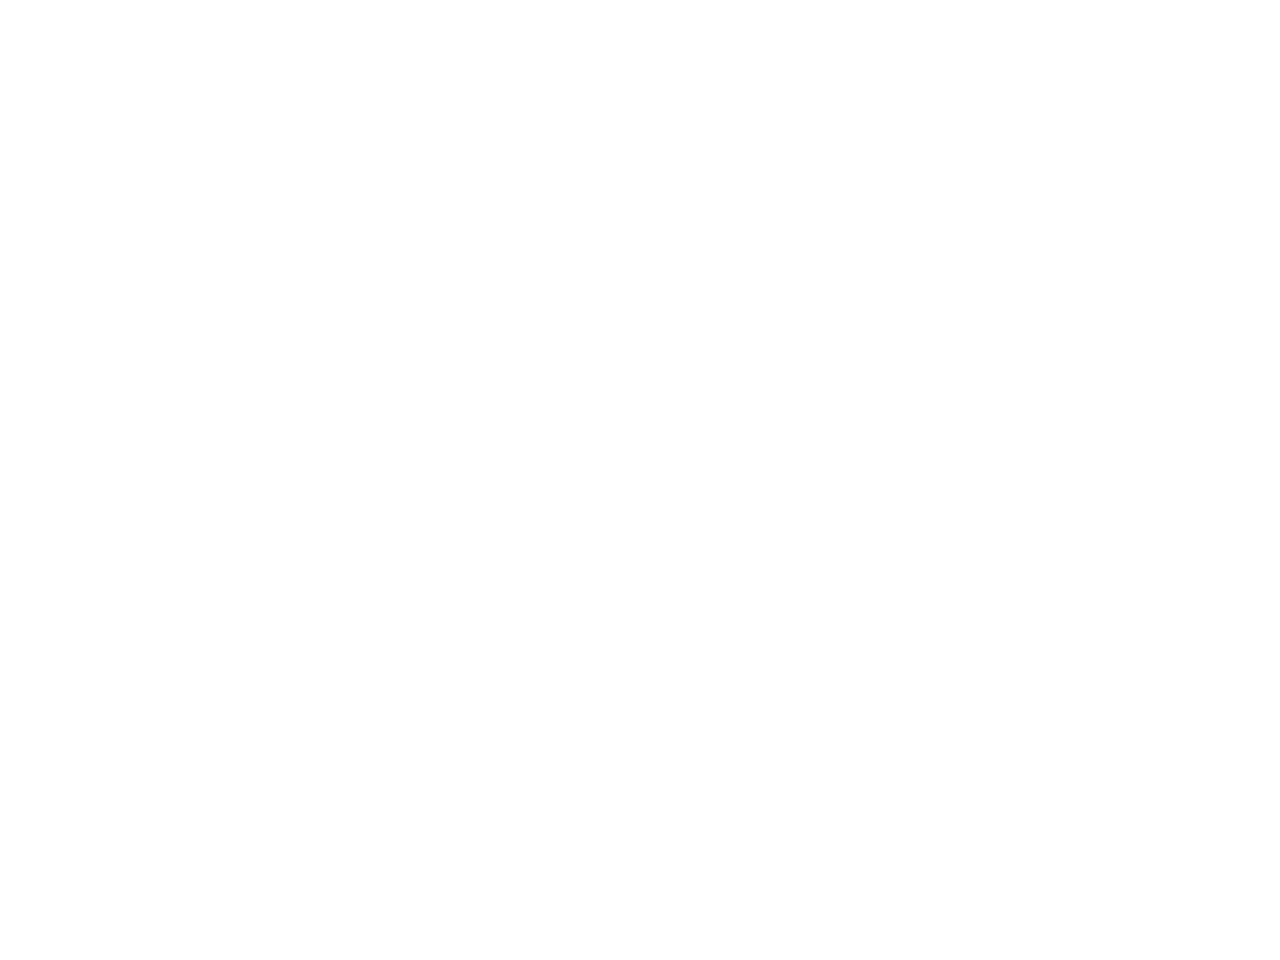

In [62]:
print("Simple forecasting model")
rmse = np.sqrt(mean_squared_error(df_all[target_column_name], df_all['predicted']))
print("[Test Data] \nRoot Mean squared error: %.2f" % rmse)
mae = mean_absolute_error(df_all[target_column_name], df_all['predicted'])
print('mean_absolute_error score: %.2f' % mae)
print('MAPE: %.2f' % MAPE(df_all[target_column_name], df_all['predicted']))

# Plot outputs
%matplotlib notebook
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(y_test, y_test, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

We did not use lags in the previous model specification. Automated ML allows you to use `target_lags` and `target_rolling_window_size`.

Now that we configured target lags, that is the previous values of the target variables, and the prediction is no longer horizon-less. We therefore must specify the `max_horizon` that the model will learn to forecast. The `target_lags` keyword specifies how far back we will construct the lags of the target variable, and the `target_rolling_window_size` specifies the size of the rolling window over which we will generate the `max`, `min` and `sum` features.

In [63]:
automl_settings_lags = {
    'time_column_name': time_column_name,
    'target_lags': 1,
    'target_rolling_window_size': 5,
    # you MUST set the max_horizon when using lags and rolling windows
    # it is optional when looking-back features are not used 
    'max_horizon': len(y_test), # only one grain
}


automl_config_lags = AutoMLConfig(task = 'forecasting',
                             debug_log = 'automl_nyc_energy_errors.log',
                             primary_metric='normalized_root_mean_squared_error',
                             iterations = 10,
                             iteration_timeout_minutes = 5,
                             X = X_train,
                             y = y_train,
                             n_cross_validations = 3,
                             path=project_folder,
                             verbosity = logging.INFO,
                            **automl_settings_lags)

In [64]:
local_run_lags = experiment.submit(automl_config_lags, show_output=True)

Running on local machine
Parent Run ID: AutoML_34df8c4e-4248-4c67-90c6-ddc187dc5f5b
The lag-lead operator was removed due to memory limitation.
The rolling window operator was removed due to memory limitation.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   RobustScaler ElasticNet                        0:00:27       0.1039    0.10

In [65]:
best_run_lags, fitted_model_lags = local_run_lags.get_output()
y_fcst_lags, X_trans_lags = fitted_model_lags.forecast(X_test, y_query)
df_lags = align_outputs(y_fcst_lags, X_trans_lags, X_test, y_test)
df_lags.head()

,timeStamp,_automl_dummy_grain_col,predicted,precip,temp,demand
0,2017-02-01 00:00:00,_automl_dummy_grain_col,4871.96,0.00,31.45,5090.62
1,2017-02-01 01:00:00,_automl_dummy_grain_col,4774.92,0.00,32.44,4839.25
2,2017-02-01 02:00:00,_automl_dummy_grain_col,4637.02,0.00,33.19,4702.52
3,2017-02-01 03:00:00,_automl_dummy_grain_col,4628.89,0.00,33.61,4629.94
4,2017-02-01 04:00:00,_automl_dummy_grain_col,4735.46,0.00,32.30,4653.38


In [66]:
print("Forecasting model with lags")
rmse = np.sqrt(mean_squared_error(df_lags[target_column_name], df_lags['predicted']))
print("[Test Data] \nRoot Mean squared error: %.2f" % rmse)
mae = mean_absolute_error(df_lags[target_column_name], df_lags['predicted'])
print('mean_absolute_error score: %.2f' % mae)
print('MAPE: %.2f' % MAPE(df_lags[target_column_name], df_lags['predicted']))

# Plot outputs
%matplotlib notebook
test_pred = plt.scatter(df_lags[target_column_name], df_lags['predicted'], color='b')
test_test = plt.scatter(y_test, y_test, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

Forecasting model with lags
[Test Data] 
Root Mean squared error: 518.62
mean_absolute_error score: 363.83
MAPE: 5.95


<IPython.core.display.Javascript object>

### 5.4 Model Explainability: What features matter for the forecast?

I can also use model explainability with Automated ML - This gives me transparency into how the model was built and what features has the most influence on the prediction.  
 
The informative features make all sorts of intuitive sense. Temperature is a strong driver of heating and cooling demand in NYC. Apart from that, the daily life cycle, expressed by `hour`, and the weekly cycle, expressed by `wday` drives people's energy use habits. 

In [68]:
from azureml.train.automl.automlexplainer import explain_model

# feature names are everything in the transformed data except the target
features = X_trans.columns[:-1]
expl = explain_model(fitted_model, X_train, X_test, features = features, best_run=best_run_lags, y_train = y_train)
# unpack the tuple
shap_values, expected_values, feat_overall_imp, feat_names, per_class_summary, per_class_imp = expl
best_run_lags

ImportError: cannot import name '_validate_lengths'

Please go to the Azure Portal's best run to see the top features chart.

The informative features make all sorts of intuitive sense. Temperature is a strong driver of heating and cooling demand in NYC. Apart from that, the daily life cycle, expressed by `hour`, and the weekly cycle, expressed by `wday` drives people's energy use habits.

## 6. Registering and deploying your model
The model registry is a way to store and organize your trained models in the Azure cloud. Models are registered in your Azure Machine Learning service workspace.

In [69]:
description = 'AutoML NYC Energy forecaster'
tags = None
model = local_run_lags.register_model(description = description, tags = tags)

print(local_run_lags.model_id)

Registering model AutoML34df8c4e4best
AutoML34df8c4e4best


### 6.1 Define your entry script & dependencies
The script contains two functions that load and run the model:

- *init()*: Typically this function loads the model into a global object. This function is run only once when the Docker container for your web service is started.
- *run(input_data)*: This function uses the model to predict a value based on the input data. Inputs and outputs to the run typically use JSON for serialization and de-serialization. You can also work with raw binary data. You can transform the data before sending to the model, or before returning to the client.


### <font color = "red"> Action Required #6 </font>
<font color = "red"> Replace the '<< modelid >>' name on line 13 with the id generated in the previous step.  </font>


In [75]:
%%writefile score_fcast.py
import pickle
import json
import numpy as np
import pandas as pd
import azureml.train.automl
from sklearn.externals import joblib
from azureml.core.model import Model


def init():
    global model
    model_path = Model.get_model_path(model_name = '<< modelid >>') # this name is model.id of model that we want to deploy
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)

timestamp_columns = ['timeStamp']

def run(rawdata, test_model = None):
    """
    Intended to process 'rawdata' string produced by
    
    {'X': X_test.to_json(), y' : y_test.to_json()}
    
    Don't convert the X payload to numpy.array, use it as pandas.DataFrame
    """
    columns = []
    target = ""
    try:
        # unpack the data frame with timestamp     
        rawobj = json.loads(rawdata)                    # rawobj is now a dict of strings
        y_pred = np.array(rawobj['y'])                  # reconstitute numpy array from serialized list
        # We do not have grain columns so we may needd to add them.
        grain_column_names = model.grain_column_names if test_model is None else test_model.grain_column_names
        X_pred = pd.read_json(rawobj['X'], convert_dates=False)   # load the pandas DF from a json string
        if grain_column_names[0] not in X_pred.columns:
            X_pred[grain_column_names[0]]=grain_column_names[0]
        X_pred.sort_index(inplace=True)
        for col in timestamp_columns:                             # fix timestamps
            if X_pred.dtypes[col] == "object":
                # Handle the string conversion to date.
                X_pred[col] = pd.to_datetime(X_pred[col]) 
            else:
                X_pred[col] = pd.to_datetime(X_pred[col], unit='ms') 
        X_copy = X_pred.copy()           
        
        if test_model is None:
            result = model.forecast(X_pred, y_pred)       # use the global model from init function
            target = model._ts_transformer.target_column_name
            index = [model.time_column_name] + model.grain_column_names
        else:
            result = test_model.forecast(X_pred, y_pred)  # use the model on which we are testing
            target = test_model._ts_transformer.target_column_name
            index = [test_model.time_column_name] + test_model.grain_column_names
        
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})
    
    # Make sure forecast is sorted in the same orger as an input, so the output Y will align.
    dfForecast = result[1]
    dfForecast.reset_index(drop=False, inplace=True)
    dfForecast = dfForecast[index + [target]]
    # Make sure index is the same.
    X_copy['ix'] = X_copy.index
    dfForecast = X_copy.merge(dfForecast, how='left', on=index)
    dfForecast.set_index('ix', drop=True, inplace=True)
    dfForecast.sort_index(inplace=True)
    dfForecast = dfForecast[timestamp_columns + [target]]
    target_vals = dfForecast.pop(target).values
    forecast_as_list = target_vals.tolist()
    return json.dumps({"forecast": forecast_as_list,   # return the minimum over the wire: 
                       "index": dfForecast.to_json()  # no forecast and its featurized values
                      })

Overwriting score_fcast.py


In [76]:
# get the model
from azureml.train.automl.run import AutoMLRun

experiment = Experiment(ws, experiment_name)
ml_run = AutoMLRun(experiment = experiment, run_id = local_run_lags.id)
best_iteration = int(str.split(best_run_lags.id,'_')[-1])      # the iteration number is a postfix of the run ID.

In [77]:
# get the best model's dependencies and write them into this file
from azureml.core.conda_dependencies import CondaDependencies

conda_env_file_name = 'fcast_env.yml'

dependencies = ml_run.get_run_sdk_dependencies(iteration = best_iteration)
for p in ['azureml-train-automl', 'azureml-sdk', 'azureml-core']:
    print('{}\t{}'.format(p, dependencies[p]))

myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn'], pip_packages=['azureml-sdk[automl]'])

myenv.save_to_file('.', conda_env_file_name)

No issues found in the SDK package versions.
azureml-train-automl	1.0.33
azureml-sdk	1.0.33
azureml-core	1.0.33.1


'fcast_env.yml'

In [78]:
# this is the script file name we wrote a few cells above
script_file_name = 'score_fcast.py'

# Substitute the actual version number in the environment file.
# This is not strictly needed in this notebook because the model should have been generated using the current SDK version.
# However, we include this in case this code is used on an experiment from a previous SDK version.

with open(conda_env_file_name, 'r') as cefr:
    content = cefr.read()

with open(conda_env_file_name, 'w') as cefw:
    cefw.write(content.replace(azureml.core.VERSION, dependencies['azureml-sdk']))

# Substitute the actual model id in the script file.

with open(script_file_name, 'r') as cefr:
    content = cefr.read()

with open(script_file_name, 'w') as cefw:
    cefw.write(content.replace('<< modelid >>' , local_run_lags.model_id))

In [79]:
from azureml.core.image import Image, ContainerImage

image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script = script_file_name,
                                 conda_file = conda_env_file_name,
                                 tags = {'type': "automl-energy-forecasting"},
                                 description = "Image for ny energy forecasting sample")

image = Image.create(name = "automl-energy-fcast-image",
                     # this is the model object 
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

image.wait_for_creation(show_output = True)

if image.creation_state == 'Failed':
    print("Image build log at: " + image.image_build_log_uri)

Creating image
Running.
NotStarted..............................................................
SucceededImage creation operation finished for image automl-energy-fcast-image:2, operation "Succeeded"


### 6.2 Define your deployment configuration
Before deploying, you must define the deployment configuration. The deployment configuration is specific to the compute target that will host the web service. For example, when deploying locally you must specify the port where the service accepts requests.

Here we use Azure Container Instances to run serverless Docker containers in Azure with simplicity and speed. 

In [80]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 2, 
                                               tags = {'type': "automl-energy-forecasting"},
                                               description = "Automl ny energy forecasting service")

In [ ]:
from azureml.core.webservice import Webservice

aci_service_name = 'automl-energy-fc-01'
print(aci_service_name)

aci_service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                           image = image,
                                           name = aci_service_name,
                                           workspace = ws)
aci_service.wait_for_deployment(True)
print(aci_service.state)
aci_service.scoring_uri

automl-energy-fc-01
Creating service
Running....

In [ ]:
print(aci_service.get_logs())